In [3]:
import matplotlib.pyplot as plt
import torch as tc
from torchdiffeq import odeint
from torch import nn


In [7]:
tmin = 0
tmax = 200 #days

tspan = tc.arange(tmin, tmax).float()

N = 10**6
I0 = 1
R0 = 0
S0 = N - I0 - R0

y0 = tc.tensor([S0, I0, R0, N]).float()

In [11]:
class ODE(nn.Module):

    def __init__(self, init_params, y0):
        super(ODE, self).__init__()
        self.init_params = init_params
        self.y0 = y0
        self.params = nn.Parameter(init_params)

    def forward(self, t, y):
        S, I, R, N = y

        dS = - self.params[0] * S * I / N
        dI = self.params[0] * S * I / N - self.params[1] * I
        dR = self.params[1] * I
        dN = tc.tensor(0.0)

        return tc.stack([dS, dI, dR, dN])

In [35]:
def simulate_data(model, params, y0, tspan):
    f = model(init_params=params, y0=y0)
    with tc.no_grad():
        S, I, R, N = odeint(f, y0, tspan).T
        S = tc.distributions.Poisson(S).sample()
        I = tc.distributions.Poisson(I).sample()
        R = tc.distributions.Poisson(R).sample()

        data = tc.distributions.Poisson(f.params[0] * S * I / N).sample()
    return data

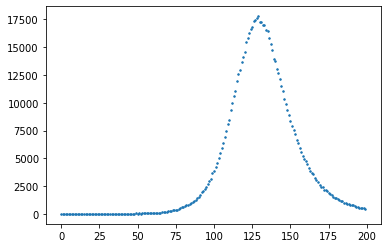

In [36]:
data = simulate_data(ODE, tc.tensor([0.2, 0.1]), y0, tspan)
plt.plot(data, '.', markersize=3)

In [38]:
def likelihood(func, data, y0, t):
    S, I, R, _ = odeint(func, y0, t).T

    pred = func.params[0] * S * I / y0[-1]

    return (1/y0[-1]) * (pred.mean() - (1/len(t)) * tc.dot(pred.log(), data))


In [41]:
func = ODE(init_params = tc.tensor([0.5, 0.3]), y0=y0)

optimizer = tc.optim.Adam(func.parameters(), lr=1e-1)

losses = []
tol = 1e-5
g = tc.tensor(1.0)
i = 0
while g > tol:
    optimizer.zero_grad()
    l = likelihood(func, data, y0, tspan)
    
    l.backward()
    if i%5==0 : print("Loss : {} , Params : {}, Grad : {} ".format(l, func.params.clone().detach(), func.params.grad))
    optimizer.step()
    g = func.params.grad.square().sum().sqrt()
    losses.append(l.clone().detach())
    i+=1

Loss : -0.0030342712998390198 , Params : tensor([0.5000, 0.3000]), Grad : tensor([ 0.2777, -0.2374]) 
Loss : -0.010902133770287037 , Params : tensor([0.4761, 0.3040]), Grad : tensor([ 0.2957, -0.2644]) 
Loss : -0.023798463866114616 , Params : tensor([0.4431, 0.3147]), Grad : tensor([ 0.2929, -0.2729]) 
Loss : -0.021817071363329887 , Params : tensor([0.3950, 0.3443]), Grad : tensor([-0.4327,  0.4245]) 
Loss : -0.02822980098426342 , Params : tensor([0.4179, 0.3052]), Grad : tensor([ 0.2394, -0.2235]) 
Loss : -0.02838200144469738 , Params : tensor([0.4108, 0.2983]), Grad : tensor([ 0.2362, -0.2204]) 
Loss : -0.031494442373514175 , Params : tensor([0.3921, 0.3043]), Grad : tensor([-0.0222,  0.0264]) 
Loss : -0.030243555083870888 , Params : tensor([0.3805, 0.3039]), Grad : tensor([-0.2004,  0.1977]) 
Loss : -0.030813846737146378 , Params : tensor([0.3763, 0.2964]), Grad : tensor([-0.1535,  0.1525]) 
Loss : -0.03146246820688248 , Params : tensor([0.3735, 0.2877]), Grad : tensor([-0.0643,  0.

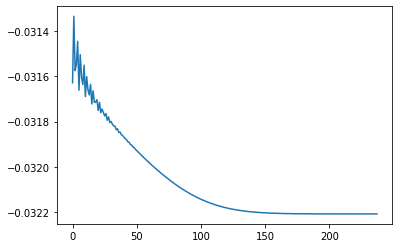

In [44]:
plt.plot(losses[50:])

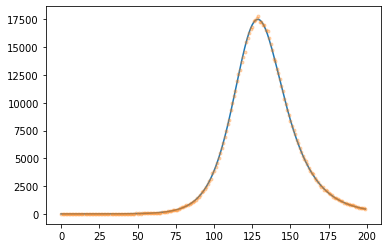

In [43]:
S, I, R, _ = odeint(func, y0, tspan).T
pred = func.params[0] * S * I / y0[-1]
plt.plot(pred.detach())
plt.plot(data.clone().detach(), '.', alpha=0.3)